In [24]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests
import time


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

The network architecture referenced in this work- https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf

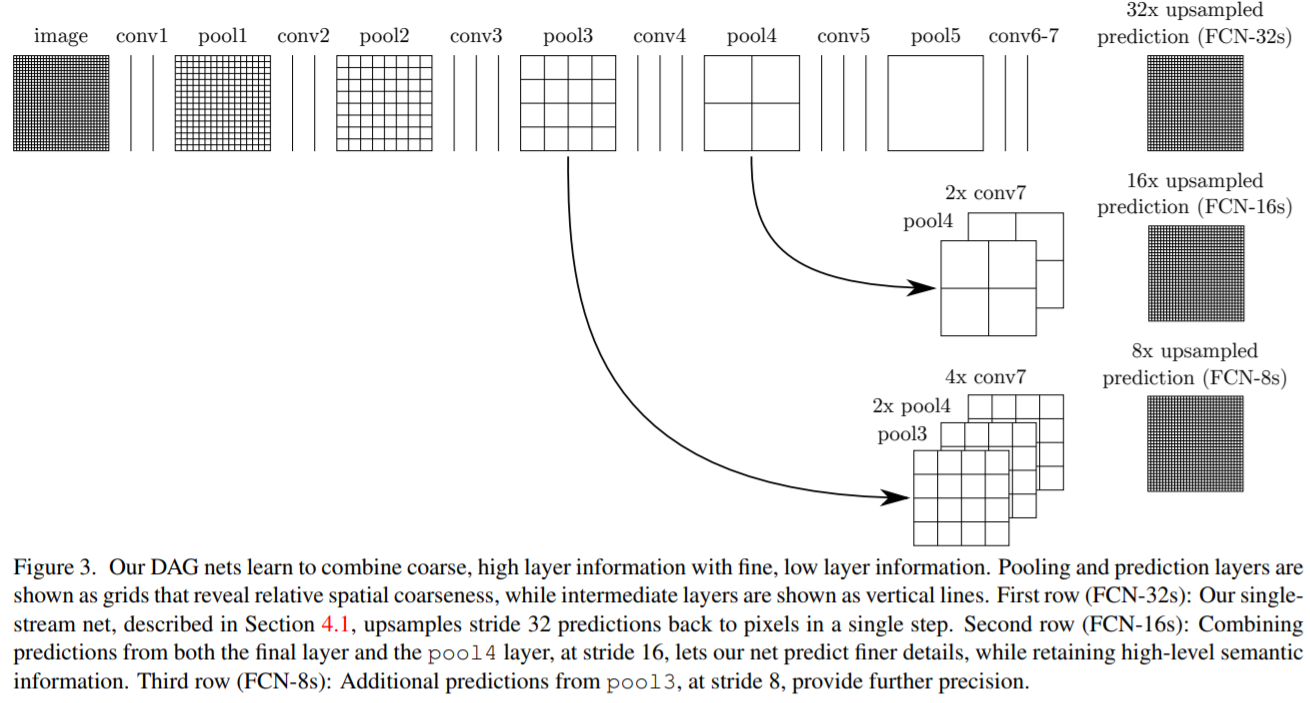

In [17]:
# Get pre-trained layers from the popular 'vgg' model

def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'

    tf.saved_model.loader.load(sess, ["vgg16"], vgg_path)
    
    graph = tf.get_default_graph()
    vgg_input_tensor = graph.get_tensor_by_name(vgg_input_tensor_name)
    vgg_keep_prob_tensor = graph.get_tensor_by_name(vgg_keep_prob_tensor_name)
    vgg_layer3_out_tensor = graph.get_tensor_by_name(vgg_layer3_out_tensor_name)
    vgg_layer4_out_tensor = graph.get_tensor_by_name(vgg_layer4_out_tensor_name)
    vgg_layer7_out_tensor = graph.get_tensor_by_name(vgg_layer7_out_tensor_name)

    return vgg_input_tensor, vgg_keep_prob_tensor, vgg_layer3_out_tensor, vgg_layer4_out_tensor, vgg_layer7_out_tensor

print('Loading Vgg Model')
tests.test_load_vgg(load_vgg, tf)


Loading Vgg Model
Tests Passed


In [1]:
# Declare parameters

L2_REG=0.001
STDEV=0.001
learning_rate=0.001
batch_size=16
KEEP_PROB=0.5
epochs=2


In [19]:
# build layers for the neural network leveraging layer 3, 4 and 7 from extracted vgg layers

def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    layer7_conv_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, 1,
                                       padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))
    output = tf.layers.conv2d_transpose(layer7_conv_1x1, num_classes, 4, 2,
                                        padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))
    layer4_conv_1x1 = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, 1,
                                       padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))
    output = tf.add(output, layer4_conv_1x1)
    output = tf.layers.conv2d_transpose(output, num_classes, 4, 2,
                                        padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))
    layer3_conv_1x1 = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, 1,
                                       padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                       kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))
    output = tf.add(output, layer3_conv_1x1)
    output = tf.layers.conv2d_transpose(output, num_classes, 16, 8,
                                        padding='same', kernel_initializer=tf.random_normal_initializer(stddev=STDEV),
                                        kernel_regularizer=tf.contrib.layers.l2_regularizer(L2_REG))   
    return output

print("Layers Test:")
tests.test_layers(layers)


Layers Test:
Tests Passed


In [21]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    labels = tf.reshape(correct_label, (-1, num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    train_op = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy_loss)
    return logits, train_op, cross_entropy_loss


print("Optimize Test:")
tests.test_optimize(optimize)

Optimize Test:
Tests Passed


In [27]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    for epoch in range(epochs):
        s_time = time.time()
        for image, targets in get_batches_fn(batch_size):
            _, loss = sess.run([train_op, cross_entropy_loss], 
                feed_dict = {input_image: image, correct_label: targets, keep_prob: KEEP_PROB ,
                             learning_rate: learning_rate })
        # Print data on the learning process
        print("Epoch: {}".format(epoch + 1), "/ {}".format(epochs), " Loss: {:.3f}".format(loss), " Time: ",
              str(timedelta(seconds=(time.time() - s_time))))
        if (epoch + 1) % 30 == 0: # Save every 20 epochs
            save_path = saver.save(sess, os.path.join(data_dir, 'cont_epoch_' + str(epoch) + '.ckpt'))
            
tests.test_train_nn(train_nn)



TypeError: The value of a feed cannot be a tf.Tensor object. Acceptable feed values include Python scalars, strings, lists, or numpy ndarrays.

In [14]:
def run():
    num_classes = 2
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    with tf.Session() as sess:
        
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)
        
        vgg_input, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
        
        output = layers(layer3, layer4, layer7, num_classes)
        
        correct_label = tf.placeholder(dtype = tf.float32, shape = (None, None, None, num_classes))        
        learning_rate = tf.placeholder(dtype = tf.float32)
        
        logits, train_op, cross_entropy_loss = optimize(output, correct_label, learning_rate, num_classes)
        
        tf.set_random_seed(123)
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver() #Simple model saver
        
        #train_nn(sess, EPOCHS, BATCH_SIZE, get_batches_fn, train_op, cross_entropy_loss, vgg_input, correct_label,
                 keep_prob, learning_rate,  saver, MODEL_DIR)
        
        # Save inference data using helper.save_inference_samples
        helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, vgg_input, num_classes)



In [15]:
run()

Tests Passed
./data\vgg
